# QUEST 평가기준

## 1. Transformer와 비교해 변경이 필요한 부분을 서술하였다.
- 제출 노트북 파일 첫부분에 텍스트 블록으로 서술합니다. 아키텍처 상 변경사항을 블럭단위로 서술합니다.
- 코드블럭에 변경사항을 주석으로 표시합니다.

## 2. 모델의 입력 형태에 맞게 전처리를 수행하였다.
- Decoder 기반의 생성모델을 감안하여 첫번 데이터를 변환합니다.
- 미완재지는 pretrain 후 fine-tuning한 데이터셋만 고려합니다.

## 3. 모델의 입력 블록을 GPT 논문에 기반하여 수정하였다.
- 모델의 input이 정상적으로 구성되었는지 확인합니다.
- 모델이 학습할 수 있도록 하는 과정을 구성합니다.

## 4. GPT 모델을 정상적으로 구성하였다. (model.summary, model.fit 결과 캡처 첨부)
- 노드의 transformer 코드를 수정하여 GPT1 모델을 구성합니다.

## 5. 입력에 따른 출력이 생성되었다.
- 출력 결과물이 수준이상 관찰이 없고 모델이 정상적으로 동작하는지 확인합니다.


In [1]:
# Transformer와 비교해 변경이 필요한 부분

# 모델 구조
    # 인코더 삭제.
    # 디코더 내 인코더-디코더 셀프어텐션 & Add & Norm 레이어 삭제

# 데이터
    # 비지도 학습 시
        # inputs와 outputs 데이터 모두 axis=0 기준으로 합친다.(validatation set을 고려한다면 사전에 분리해야한다.)
        # Auto-Regressive 학습 시 데이터와 마찬가지로 t-n ~ t-1 개의 inputs와 t인 output으로 데이터를 생성한다.

    # 지도 학습 시
        # transformer에 사용한 데이터와 동일하게 사용한다.
        # inputs 와 outputs(label)

# 학습 방법
    # 비지도학습 이후 (동일한 모델로) 지도학습을 수행한다.
    # 비지도 학습 시 위에서 언급한 데이터를 활용하여 학습한다.
    # 지도 학습 시, 위에서 언급한 데이터로 학습한다.
    
# 손실함수(목적함수)
    # 비지도 학습 시 : SparseCategoricalCrossentropy 사용, sgd를 활용하여 최적화 한다.
    # 지도 학습 시 : SparseCategoricalCrossentropy + 람다*비지도학습의 SparseCategoricalCrossentropy

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## 비지도 학습

In [3]:
# 비지도 학습용 데이터 준비

import pandas as pd
# 데이터 로드
# https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv
# 송영숙님이 공개한 챗봇 데이터
data_path = os.path.join('~/aiffel/transformer_chatbot/data/ChatbotData .csv')
origin_data_df = pd.read_csv(data_path)
origin_data_df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 앞뒤로 공백 추가
  sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백 한개의 공백으로

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z\u1100-\u11FF\uAC00-\uD7AF.,?!]", " ", sentence)
  sentence = sentence.strip()
  return sentence

# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs = origin_data_df['Q'].apply(preprocess_sentence).values
    outputs = origin_data_df['A'].apply(preprocess_sentence).values
    
    return inputs, outputs

In [5]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [6]:
print('전처리 후의 1998번째 질문 샘플: {}'.format(questions[1998]))
print('전처리 후의 1998번째 답변 샘플: {}'.format(answers[1998]))

전처리 후의 1998번째 질문 샘플: 배가 너무 고파
전처리 후의 1998번째 답변 샘플: 뭐 좀 챙겨드세요 .


In [7]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(np.concatenate((questions, answers), axis=0), target_vocab_size=2**13)

In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8138]
END_TOKEN의 번호 : [8139]


In [9]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8140


In [10]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1998번째 질문 샘플: {}'.format(tokenizer.encode(questions[1998])))
print('정수 인코딩 후의 1998번째 답변 샘플: {}'.format(tokenizer.encode(answers[1998])))

정수 인코딩 후의 1998번째 질문 샘플: [7115, 6, 111, 1125]
정수 인코딩 후의 1998번째 답변 샘플: [156, 23, 2808, 1]


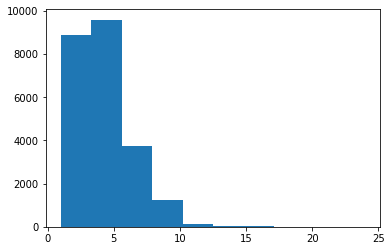

In [11]:
temp = list(map(lambda x : len(x.split()), np.concatenate((questions, answers), axis=0)))
temp[:5]

plt.hist(temp)
plt.show()

In [12]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 10
print(MAX_LENGTH)

10


In [13]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 10으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [14]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8140
필터링 후의 질문 샘플 개수: 9103
필터링 후의 답변 샘플 개수: 9103


In [15]:
type(questions)

numpy.ndarray

In [39]:
# Auto-Regressive를 위한 데이터 만들기

# axis=0으로 데이터 합치기
ar_data_set = np.concatenate((questions, answers), axis=0)
ar_data_set.shape, ar_data_set[:5]

((18206, 10),
 array([[8138, 5162, 3053,   41, 8139,    0,    0,    0,    0,    0],
        [8138,   46,  918, 7914,  994, 1719, 8139,    0,    0,    0],
        [8138, 3539,   86, 3647,   68, 8139,    0,    0,    0,    0],
        [8138, 3539,   86, 1389, 3647,   68, 8139,    0,    0,    0],
        [8138, 7994, 7994, 7990, 7914, 4178, 8139,    0,    0,    0]],
       dtype=int32))

In [40]:
# ar_data_set에 교사 강요(Teacher Forcing) 적용
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
ar_data_set = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': ar_data_set[:, :-1],
    },
    {
        'outputs': ar_data_set[:, 1:]
    },
))

ar_data_set = ar_data_set.cache()
ar_data_set = ar_data_set.shuffle(BUFFER_SIZE)
ar_data_set = ar_data_set.batch(BATCH_SIZE)
ar_data_set = ar_data_set.prefetch(tf.data.experimental.AUTOTUNE)

In [41]:
# 디코더 모델 생성

# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스크 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스킹 구현 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 디코더 생성하기
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [42]:
# 트랜스포머 모델 생성 함수
def gpt1(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="gpt1"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

In [43]:
# gpt1 모델 생성하기
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt1(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
dec_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 256)    3138048     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]         

In [44]:
# 손실함수 정의하기
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [45]:
# 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [46]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [47]:
# 비지도 학습하기
EPOCHS = 10
model.fit(ar_data_set, epochs=EPOCHS, verbose=1)

Epoch 1/10
285/285 [==============================] - 23s 15ms/step - loss: 5.2866 - accuracy: 0.0931
Epoch 2/10
285/285 [==============================] - 4s 15ms/step - loss: 4.1985 - accuracy: 0.1465
Epoch 3/10
285/285 [==============================] - 4s 15ms/step - loss: 3.8048 - accuracy: 0.1691
Epoch 4/10
285/285 [==============================] - 4s 15ms/step - loss: 3.5565 - accuracy: 0.1834
Epoch 5/10
285/285 [==============================] - 4s 15ms/step - loss: 3.3061 - accuracy: 0.1993
Epoch 6/10
285/285 [==============================] - 4s 15ms/step - loss: 3.0432 - accuracy: 0.2199
Epoch 7/10
285/285 [==============================] - 4s 15ms/step - loss: 2.7704 - accuracy: 0.2428
Epoch 8/10
285/285 [==============================] - 4s 15ms/step - loss: 2.5062 - accuracy: 0.2660
Epoch 9/10
285/285 [==============================] - 4s 15ms/step - loss: 2.2634 - accuracy: 0.2896
Epoch 10/10
285/285 [==============================] - 4s 15ms/step - loss: 2.0489 - accur

## 지도학습

In [49]:
# 지도학습 할 데이터 준비

# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [50]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8140
필터링 후의 질문 샘플 개수: 9103
필터링 후의 답변 샘플 개수: 9103


In [51]:
# 디코더에 교사 강요(Teacher Forcing) 적용
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions
    },
    {
        'outputs': answers
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 손실함수 정의하기
def loss_function2(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss1 = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss1 = tf.multiply(loss1, mask)

  

  return tf.reduce_mean(loss)